## Preliminary Setup

### **Important: Execute this cell before proceeding**


In [ ]:
################################ Necessary Libraries ################################
import json  # Handling JSON data
import numpy as np  # Numerical operations
import scipy.stats as stats  # Statistical functions
import robustats as rs  # Robust statistics library
import pandas as pd  # Data manipulation
import os  # OS-level operations
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Advanced visualization
from sklearn.preprocessing import LabelEncoder  # Encoding categorical labels
from sklearn.preprocessing import OneHotEncoder  # One-hot encoding for categorical data
from scipy.special import loggamma
from cleaning import * # general helper functions and cleaning data for plotting
import string

import warnings 
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
# Suppress FutureWarning related to DataFrame concatenation
warnings.simplefilter(action='ignore', category=FutureWarning)
# Initialize lists to store predictions, outcomes, and question identifiers
predictions = []
outcomes = []
qs = []

# Get list of CSV files in the 'questions' directory
options = os.listdir('figures_data')
options = [k for k in options if k.endswith('.csv')]  # Filter only CSV files
index = find_index(options, 'Will_Donald_Trump_be_president_of_the_US_in_2019_.csv')

choice = options[index]

X = pd.read_csv(f'figures_data/{choice}')

# Filter only forecaster-submitted predictions
dta = X.loc[X.grouping == 'forecasters'].copy()  # .copy() prevents SettingWithCopyWarning

# Convert 'Time' column to datetime format
dta.loc[:, 'Time'] = pd.to_datetime(dta['Time'])

# Encode prediction values into 5 bins
label_encoder = LabelEncoder()
dta.loc[:, 'Bin'] = label_encoder.fit_transform(pd.cut(dta['Prediction'], 5, retbins=True)[0]).astype(int)

# Assign uniform step indices (useful for ordering)
dta.loc[:, 'uniform_step'] = np.arange(len(dta))

# Replace X with the processed dataset
X = dta.copy()

# One-hot encoding for categorical bin values
enc = OneHotEncoder(handle_unknown='ignore')
encoded_bins = enc.fit_transform(X[['Bin']]).toarray()

# Convert encoded bins to DataFrame with labeled columns
Z = pd.DataFrame(encoded_bins, columns=['A', 'B', 'C', 'D', 'E'])

# Extract resolution value
res = int(X['resolution'].iloc[0])

## Figure 1
Loads and visualizes probability forecasts from Metaculus for the question:  
**"Will Donald Trump be president of the US in 2019?"**


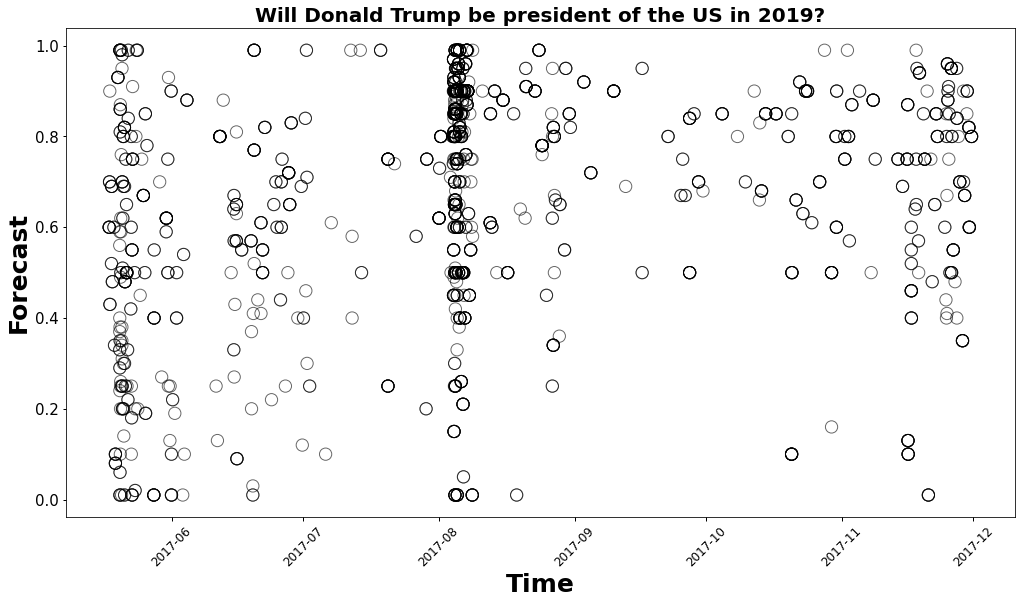

In [ ]:
# Create the figure
fig, ax = plt.subplots(figsize=(17, 9), facecolor=(1, 1, 1))

# Scatter plot: Forecast probability over time
sns.scatterplot(
    data=X, 
    x='Time', 
    y='Prediction', 
    ax=ax, 
    marker='o', 
    s=150,  # Marker size
    edgecolor='black',  # Black border
    facecolors='none',  # Hollow circles
    alpha=0.6           # Transparency level
)

ax.set_title(
    choice.replace('_.csv', '').replace('_', ' ') + "?", 
    fontsize=20, fontweight='bold'
)

# Formatting: bold axis labels, larger fonts, rotated x-axis labels
ax.set_xlabel('Time', fontsize=25, fontweight='bold')
ax.set_ylabel('Forecast', fontsize=25, fontweight='bold')
ax.tick_params(axis='x', which='both', labelsize=12, color='black', width=1, rotation=45)
ax.tick_params(axis='y', which='both', labelsize=15, color='black', width=1)

plt.show()


## Figure 2: Forecast Probability with Change Point Annotations


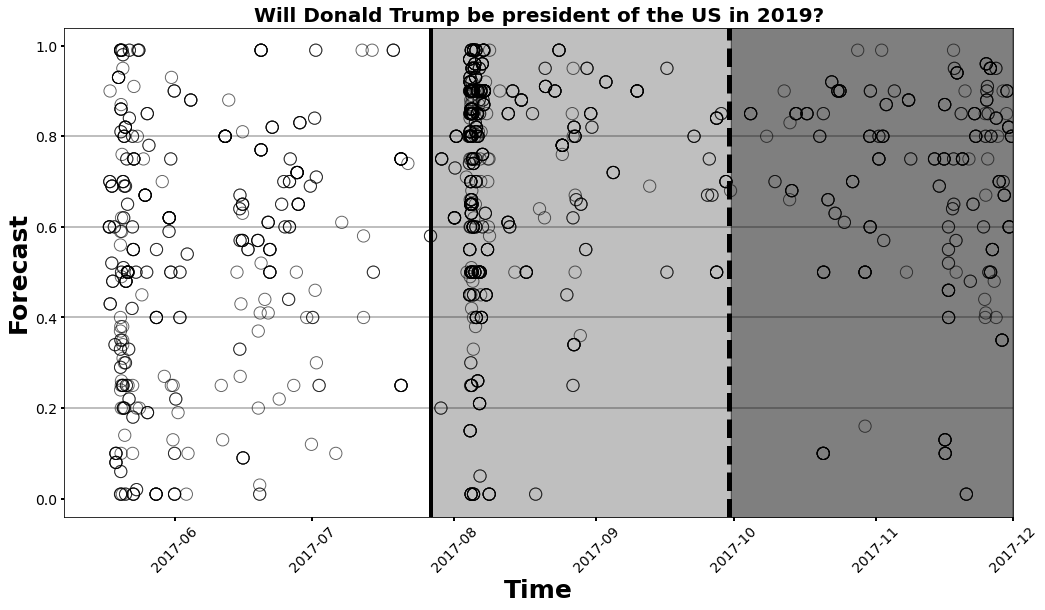

In [ ]:
# Create the figure
fig, ax = plt.subplots(figsize=(17, 9), facecolor=(1, 1, 1))

sns.scatterplot(
    data=X, 
    x='Time', 
    y='Prediction', 
    color='black', 
    ax=ax, 
    marker='o', 
    s=150,  # Marker size
    edgecolor='black',  # Black border
    facecolors='none',  # Hollow circles
    alpha=0.6           # Transparency level
)
ax.set_ylim(-0.15, 1.15)
ax.fill_between(
    X.Time[X.Time > pd.to_datetime('2017-09-30')],
    ax.get_ylim()[0], 
    ax.get_ylim()[1], 
    color='black', 
    alpha=0.5, 
    label='Future Data'
)
ax.fill_between(
    X.Time[(X.Time < pd.to_datetime('2017-10-04')) & (X.Time > pd.to_datetime('2017-07-22'))],
    ax.get_ylim()[0], 
    ax.get_ylim()[1], 
    color='black', 
    alpha=0.25, 
    label='Transition Period'
)
ax.set_title(
    choice.replace('_.csv', '').replace('_', ' ') + "?", 
    fontsize=20, fontweight='bold'
)
ax.set_xlabel('Time', fontsize=25, fontweight='bold')
ax.set_ylabel('Forecast', fontsize=25, fontweight='bold')
ax.tick_params(axis='x', labelsize=14, color='black', width=2, rotation=45)
ax.tick_params(axis='y', labelsize=14, color='black', width=2)
for i in [0.2, 0.4, 0.6, 0.8]:
    ax.axhline(y=i, lw=2, color='black', alpha=0.25, linestyle='-')
ax.axvline(x=pd.to_datetime('2017-07-27'), color='black', lw=4, label='Proposed Change Point')
ax.axvline(x=pd.to_datetime('2017-09-30'), color='black', linestyle='--', linewidth=5, label='Significant Date')
ax.set_xlim(ax.get_xlim()[0], pd.to_datetime('2017-12-01'))
ax.set_ylim(-0.04, 1.04)
plt.show()

## Figure 3 

### a)

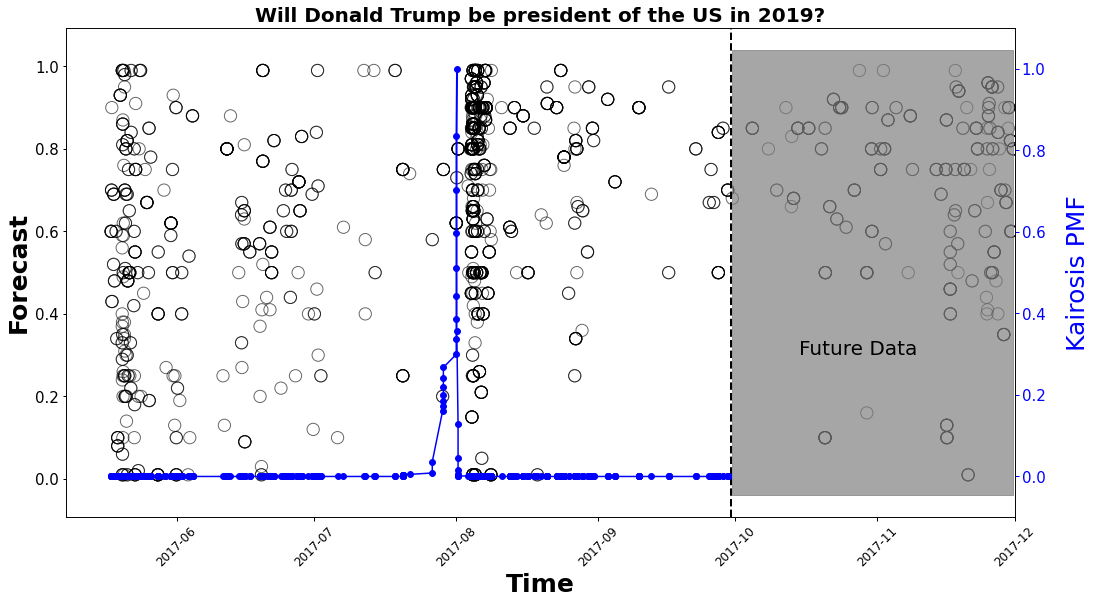

In [ ]:
################################ Run Single PMF ################################
data = X
cutoff = X[X.Time < pd.to_datetime('2017-09-30')].shape[0]
label_encoder = LabelEncoder()
data['Bin'] = label_encoder.fit_transform(pd.cut(data['Prediction'], 5, retbins=True)[0])

# One-hot encode the binned predictions
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
bin_encoded = one_hot_encoder.fit_transform(data[['Bin']]).toarray()
bin_df = pd.DataFrame(bin_encoded, columns=getLabs(5))  # Assuming getLabs is predefined for bin labels
pmf = []
calc = bin_df.head(cutoff)
for j in range(1,cutoff + 1):
    pmf.append(two_sample_log(
        np.repeat(j*0.2, 5),
        np.repeat(1, 5),
        calc[calc.index <= j].sum().values,
        calc[calc.index > j].sum().values,
    ))
regpmf =(np.exp((pmf) - np.max(pmf)))
cmf = (np.exp((pmf) - np.max(pmf))
    / np.exp((pmf) - np.max(pmf)).sum()).cumsum()

y_values = regpmf

################################ Plotting Figure ################################

fig, ax = plt.subplots(figsize=(17, 9), facecolor=(1, 1, 1))

# Scatter plot: Forecast probability over time
sns.scatterplot(
    data=X, 
    x='Time', 
    y='Prediction', 
    color='black', 
    ax=ax, 
    marker='o', 
    s=150,  # Marker size
    edgecolor='black',  # Black border
    facecolors='none',  # Hollow circles
    alpha=0.6           # Transparency level
)

ax.axvline(pd.to_datetime('2017-09-30'), color='black', linestyle='--', linewidth=2)

ax.fill_between(
    X.Time[X.Time > pd.to_datetime('2017-09-30')],
    ax.get_ylim()[0], 
    ax.get_ylim()[1], 
    color='grey', 
    alpha=0.7
)
ax.text(pd.to_datetime('2017-10-15'), 0.3, 'Future Data', fontsize=20)
ax.set_title(
    choice.replace('_.csv', '').replace('_', ' ') + "?", 
    fontsize=20, fontweight='bold'
)
ax.set_xlabel('Time', fontsize=25, fontweight='bold')
ax.set_ylabel('Forecast', fontsize=25, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, color='black', width=1, rotation=45)
ax.tick_params(axis='y', labelsize=15, color='black', width=1)
ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=15, color='black', width=1)
ax2.set_ylabel('Kairosis PMF', fontsize=25, labelpad=20, color='blue')
ax2.scatter(
    X.Time[X.Time < pd.to_datetime('2017-09-30')], 
    y_values,
    label='Kairosis PMF', 
    s=35, 
    color='blue'
)
ax2.plot(
    X.Time[X.Time < pd.to_datetime('2017-09-30')], 
    y_values,
    linestyle='-', 
    color='blue'
)
ax2.tick_params(axis='y', labelsize=15, colors='blue', width=1)
ax2.set_ylim(y_values.min() - 0.1, y_values.max() + 0.1)
plt.xlim(ax.get_xlim()[0], pd.to_datetime('2017-12-01'))
plt.show()

### b)

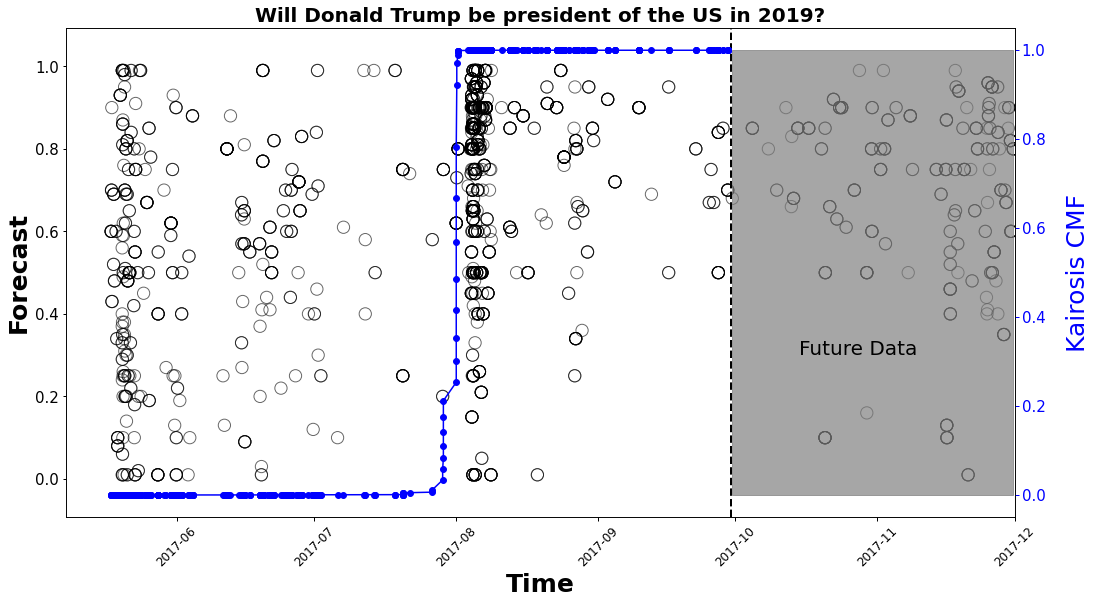

In [5]:
# Load PMF values for Kairosis model
y_values = cmf

# Create the figure
fig, ax = plt.subplots(figsize=(17, 9), facecolor=(1, 1, 1))

# Scatter plot: Forecast probability over time
sns.scatterplot(
    data=X, 
    x='Time', 
    y='Prediction', 
    color='black', 
    ax=ax, 
    marker='o', 
    s=150,  # Marker size
    edgecolor='black',  # Black border
    facecolors='none',  # Hollow circles
    alpha=0.6           # Transparency level
)

# Vertical dashed line at key date (2017-09-30)
ax.axvline(pd.to_datetime('2017-09-30'), color='black', linestyle='--', linewidth=2)

# Highlight future data region with a shaded gray area
ax.fill_between(
    X.Time[X.Time > pd.to_datetime('2017-09-30')],
    ax.get_ylim()[0], 
    ax.get_ylim()[1], 
    color='grey', 
    alpha=0.7
)

# Add text annotation for future data region
ax.text(pd.to_datetime('2017-10-15'), 0.3, 'Future Data', fontsize=20)

# Set dynamic title based on dataset name
ax.set_title(
    choice.replace('_.csv', '').replace('_', ' ') + "?", 
    fontsize=20, fontweight='bold'
)

# Formatting: bold axis labels, larger fonts, rotated x-axis labels
ax.set_xlabel('Time', fontsize=25, fontweight='bold')
ax.set_ylabel('Forecast', fontsize=25, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, color='black', width=1, rotation=45)
ax.tick_params(axis='y', labelsize=15, color='black', width=1)

# Add secondary y-axis for Kairosis PMF
ax2 = ax.twinx()
ax2.tick_params(axis='y', labelsize=15, color='black', width=1)
ax2.set_ylabel('Kairosis CMF', fontsize=25, labelpad=20, color='blue')

# Scatter plot and line plot for Kairosis PMF
ax2.scatter(
    X.Time[X.Time < pd.to_datetime('2017-09-30')], 
    y_values,
    label='Kairosis PMF', 
    s=35, 
    color='blue'
)
ax2.plot(
    X.Time[X.Time < pd.to_datetime('2017-09-30')], 
    y_values,
    linestyle='-', 
    color='blue'
)

# Adjust axis colors and limits
ax2.tick_params(axis='y', labelsize=15, colors='blue', width=1)

# Synchronize x-axis limits
plt.xlim(ax.get_xlim()[0], pd.to_datetime('2017-12-01'))

# Show the plot
plt.show()

## Table 1 Computing Skill Scores for Forecast Evaluation

**Runtime <30s**

In [ ]:
paths = ['intermediary/table_1_forecasts/' + i for i in os.listdir('intermediary/table_1_forecasts/')]
skills = []
for path in (paths):    
    try:
        df = pd.read_pickle(path)
        df['IJF'] = [0.5,0.5,0.5]
        forecast_columns = ['median', 'mean', 'kairosis_median', 'kairosis_mean', 'twenty_median', 'twenty_mean', 'geom_median', 'geom_mean', 'IJF']
        scoredf = df.copy()
        # Apply Brier score to each forecast in each row, using 'resolution' as the outcome
        for col in forecast_columns:
            scoredf[f'brier_{col}'] = scoredf.apply(lambda row: brier_score(row[col], row['resolution']), axis=1)
            scoredf[f'log_{col}'] = scoredf.apply(lambda row: log_score(row[col], row['resolution']), axis=1)
        scoredf = scoredf.drop(columns = forecast_columns)
        unweighted = pd.DataFrame([scoredf.iloc[:, 2:].mean()])
        weighted = pd.DataFrame([(scoredf.iloc[:, 2:]).mul((scoredf['weight']/scoredf['weight'].sum()), axis = 0).sum()])
        res = pd.concat([unweighted, weighted])
        res.index =  ['unweighted', 'weighted']
        brier_columns = [f'brier_{col}' for col in forecast_columns]
        log_columns = [f'log_{col}' for col in forecast_columns]
        res = res[brier_columns + log_columns]
        brier = res[brier_columns].T
        logs = res[log_columns].T
        brieruw = pd.DataFrame(brier.unweighted)
        brierw = pd.DataFrame(brier.weighted)
        loguw = pd.DataFrame(logs.unweighted)
        logw = pd.DataFrame(logs.weighted)
        brier_uw_skills = []
        brier_w_skills = []
        log_uw_skills = []
        log_w_skills = []

        for i in (brieruw.index[1:]):
            brier_uw_skills.append(skillscorebrier(brieruw.loc['brier_median'].values[0], brieruw.loc[i].values[0]))
            brier_w_skills.append(skillscorebrier(brierw.loc['brier_median'].values[0], brierw.loc[i].values[0]))
        for i in loguw.index[1:]:
            log_uw_skills.append(skillscorebrier(loguw.loc['log_median'].values[0], loguw.loc[i].values[0]))
            log_w_skills.append(skillscorebrier(logw.loc['log_median'].values[0], logw.loc[i].values[0]))
        skillscores = pd.DataFrame([brier_uw_skills, brier_w_skills,log_uw_skills,log_w_skills]).T
        skillscores.index =['mean', 'kairosis_median', 'kairosis_mean',
            'twenty_median', 'twenty_mean', 'geom_median',
            'geom_mean', 'IJF']
        skillscores.columns = ['Unweighted Brier Score', 'Weighted Brier Score', 'Unweighted Log Score', 'Weighted Log Score']
        skills.append(skillscores)
    except Exception as e:
        print(f"Error: {e}")
        continue
totalskill_check = pd.concat(skills)
totalskill = totalskill_check
cols = []

#######################################################
#unweighted brier
#medians
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Unweighted Brier Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Unweighted Brier Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Unweighted Brier Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Unweighted Brier Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Unweighted Brier Score'].values

#means
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Unweighted Brier Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Unweighted Brier Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Unweighted Brier Score'].values

uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T

uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = uwbs
cols.append(testdta.mean())

#######################################################
#weighted brier
#medians
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Weighted Brier Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Weighted Brier Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Weighted Brier Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Weighted Brier Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Weighted Brier Score'].values

#means
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Weighted Brier Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Weighted Brier Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Weighted Brier Score'].values

uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T

uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = uwbs


cols.append(testdta.mean())

#######################################################
#unweighted log
#medians
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Unweighted Log Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Unweighted Log Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Unweighted Log Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Unweighted Log Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Unweighted Log Score'].values

#means
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Unweighted Log Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Unweighted Log Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Unweighted Log Score'].values

uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T

uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = uwbs


cols.append(testdta.mean())

#######################################################
#weighted log
#medians
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Weighted Log Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Weighted Log Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Weighted Log Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Weighted Log Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Weighted Log Score'].values

#means
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Weighted Log Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Weighted Log Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Weighted Log Score'].values

uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T

uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = uwbs

cols.append(testdta.mean())
table1 = pd.DataFrame(cols)
table1['median'] = [0,0,0,0]
table1 = (table1.T).round(3)

# Define the desired row order
desired_row_order = [
    'median', 'mean',
    'kairosis_median', 'kairosis_mean', 
    'twenty_median', 'twenty_mean', 
    'geom_median', 'geom_mean', 
    'IJF'
]
scores_df_reordered = table1.loc[desired_row_order]
scores_df_reordered.columns = ['Brier UW','Brier W','Log UW','Log W']

############################# SDS #############################

skills = []
for path in (paths):    
        df = pd.read_pickle(path)
        df['IJF'] = [0.5,0.5,0.5]

        forecast_columns = ['median', 'mean', 'kairosis_median', 'kairosis_mean', 'twenty_median', 'twenty_mean', 'geom_median', 'geom_mean', 'IJF']
        scoredf = df.copy()
        # Apply Brier score to each forecast in each row, using 'resolution' as the outcome
        for col in forecast_columns:
            scoredf[f'brier_{col}'] = scoredf.apply(lambda row: brier_score(row[col], row['resolution']), axis=1)
            scoredf[f'log_{col}'] = scoredf.apply(lambda row: log_score(row[col], row['resolution']), axis=1)
        scoredf = scoredf.drop(columns = forecast_columns)
        unweighted = pd.DataFrame([scoredf.iloc[:, 2:].mean()])
        weighted = pd.DataFrame([(scoredf.iloc[:, 2:]).mul((scoredf['weight']/scoredf['weight'].sum()), axis = 0).sum()])
        res = pd.concat([unweighted, weighted])
        res.index =  ['unweighted', 'weighted']
        brier_columns = [f'brier_{col}' for col in forecast_columns]
        log_columns = [f'log_{col}' for col in forecast_columns]
        res = res[brier_columns + log_columns]
        brier = res[brier_columns].T
        logs = res[log_columns].T
        brieruw = pd.DataFrame(brier.unweighted)
        brierw = pd.DataFrame(brier.weighted)
        loguw = pd.DataFrame(logs.unweighted)
        logw = pd.DataFrame(logs.weighted)
        brier_uw_skills = []
        brier_w_skills = []
        log_uw_skills = []
        log_w_skills = []

        for i in (brieruw.index[1:]):
            brier_uw_skills.append(skillscorebrier(brieruw.loc['brier_median'].values[0], brieruw.loc[i].values[0]))
            brier_w_skills.append(skillscorebrier(brierw.loc['brier_median'].values[0], brierw.loc[i].values[0]))
        for i in loguw.index[1:]:
            log_uw_skills.append(skillscorebrier(loguw.loc['log_median'].values[0], loguw.loc[i].values[0]))
            log_w_skills.append(skillscorebrier(logw.loc['log_median'].values[0], logw.loc[i].values[0]))
        skillscores = pd.DataFrame([brier_uw_skills, brier_w_skills,log_uw_skills,log_w_skills]).T
        skillscores.index =['mean', 'kairosis_median', 'kairosis_mean',
            'twenty_median', 'twenty_mean', 'geom_median',
            'geom_mean', 'IJF']
        skillscores.columns = ['Unweighted Brier Score', 'Weighted Brier Score', 'Unweighted Log Score', 'Weighted Log Score']
        skills.append(skillscores)
totalskill_check = pd.concat(skills)
totalskill = totalskill_check
cols = []

#######################################################
#unweighted brier
#medians
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Unweighted Brier Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Unweighted Brier Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Unweighted Brier Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Unweighted Brier Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Unweighted Brier Score'].values

#means
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Unweighted Brier Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Unweighted Brier Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Unweighted Brier Score'].values

uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T

uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = uwbs
cols.append(np.round(np.sqrt(testdta.var()/testdta.shape[0]),3))

#######################################################
#weighted brier
#medians
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Weighted Brier Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Weighted Brier Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Weighted Brier Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Weighted Brier Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Weighted Brier Score'].values

#means
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Weighted Brier Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Weighted Brier Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Weighted Brier Score'].values

uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T

uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = uwbs


cols.append(np.round(np.sqrt(testdta.var()/testdta.shape[0]),3))

#######################################################
#unweighted log
#medians
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Unweighted Log Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Unweighted Log Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Unweighted Log Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Unweighted Log Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Unweighted Log Score'].values

#means
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Unweighted Log Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Unweighted Log Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Unweighted Log Score'].values

uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T

uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = uwbs


cols.append(np.round(np.sqrt(testdta.var()/testdta.shape[0]),3))

#######################################################
#weighted log
#medians
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Weighted Log Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Weighted Log Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Weighted Log Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Weighted Log Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Weighted Log Score'].values

#means
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Weighted Log Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Weighted Log Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Weighted Log Score'].values

uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T

uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = uwbs

cols.append(np.round(np.sqrt(testdta.var()/testdta.shape[0]),3))
table1 = pd.DataFrame(cols)
table1['median'] = [0,0,0,0]
table1 = (table1.T).round(3)

# Define the desired row order
desired_row_order = [
    'median', 'mean',
    'kairosis_median', 'kairosis_mean', 
    'twenty_median', 'twenty_mean', 
    'geom_median', 'geom_mean', 
    'IJF'
]
sds_df_reordered = table1.loc[desired_row_order]
sds_df_reordered.columns = ['Brier UW','Brier W','Log UW','Log W']

table1_presented = scores_df_reordered.astype(str) + " (" + sds_df_reordered.astype(str) + ")"
# DataFrame to store results
aggregated_scores = pd.DataFrame(columns=table1_presented.index[:-1].values)

for file in paths:
    df = pd.read_pickle(file).iloc[:, 1:]  
    df['IJF'] = [0.5, 0.5, 0.5]  # Assign a constant forecast for IJF
    brier_scores = calculate_brier_scores(df)
    score_summary = pd.DataFrame(brier_scores.mean()).T
    aggregated_scores = pd.concat([aggregated_scores, score_summary])

brier_summary = pd.DataFrame({
    'Score': aggregated_scores.mean()*-1,
    'Standard Deviation': np.sqrt(aggregated_scores.var() / aggregated_scores.shape[0])
})

t1 = pd.concat([pd.DataFrame(brier_summary['Score'].round(3).astype(str) + ' (' + brier_summary['Standard Deviation'].round(3).astype(str) + ')', columns = ['Brier Score']), table1_presented], axis = 1)

print(t1)

                    Brier Score         Brier UW          Brier W  \
median           -0.143 (0.006)        0.0 (0.0)        0.0 (0.0)   
mean             -0.147 (0.005)    -0.66 (0.135)   -0.655 (0.134)   
kairosis_median  -0.134 (0.006)    0.069 (0.008)    0.064 (0.008)   
kairosis_mean    -0.139 (0.005)   -0.545 (0.134)   -0.547 (0.133)   
twenty_median    -0.143 (0.006)   -0.147 (0.067)   -0.172 (0.069)   
twenty_mean      -0.144 (0.005)   -0.705 (0.345)   -0.736 (0.356)   
geom_median       -0.15 (0.006)   -0.227 (0.036)   -0.272 (0.041)   
geom_mean        -0.148 (0.006)   -0.464 (0.076)   -0.494 (0.078)   
IJF                 -0.25 (0.0)  -18.606 (5.655)  -18.471 (5.651)   

                         Log UW           Log W  
median                0.0 (0.0)       0.0 (0.0)  
mean             -0.202 (0.022)    -0.2 (0.022)  
kairosis_median   0.051 (0.006)   0.046 (0.006)  
kairosis_mean    -0.142 (0.022)  -0.145 (0.022)  
twenty_median    -0.017 (0.015)  -0.029 (0.016)  
twenty_me

## Figure 4 (a) - (e)

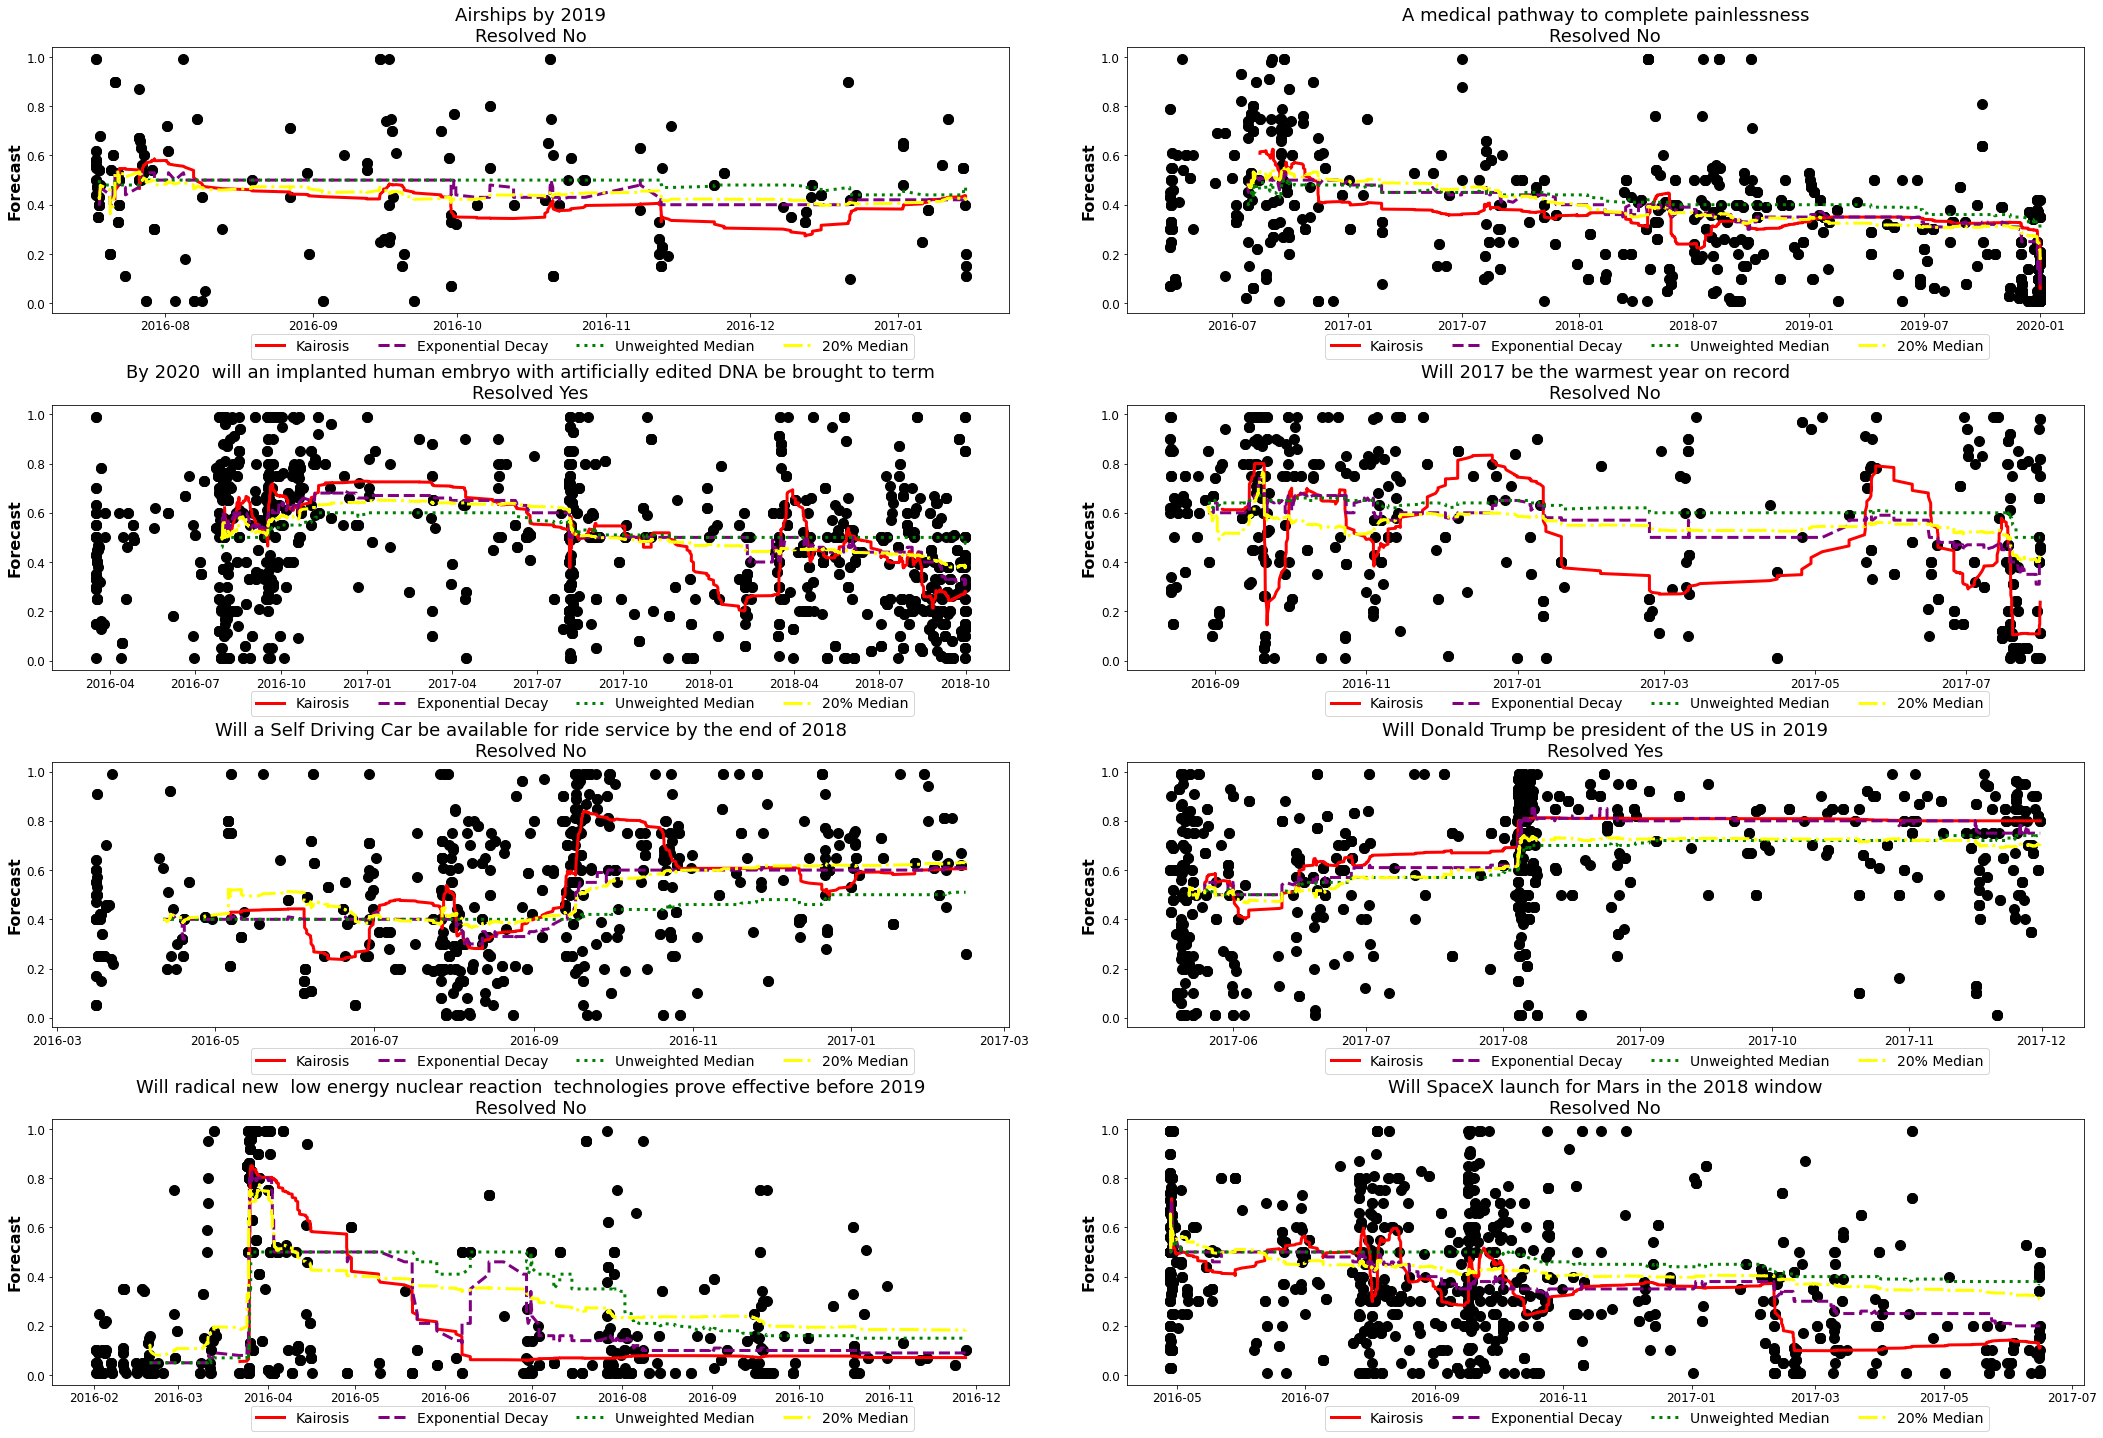

In [7]:
# Load forecast files
figure_4_questions = os.listdir('figures_data')
figure_4_questions = [k for k in options if k.endswith('.csv')]  # Filter only CSV files
figure_4_forecasts = [i.replace( '.csv','_forecasts.pkl') for i in figure_4_questions]

# Create a 4x2 figure grid
fig, axes = plt.subplots(4, 2, figsize=(30, 20), facecolor=(1,1,1))
axes = axes.flatten()  # Flatten axes for easy iteration

# Define colors and line styles for forecasts
colors = ['red', 'purple', 'green', 'yellow']
styles = ['-', '--', 'dotted', 'dashdot']
labels = ['Kairosis', 'Exponential Decay', 'Unweighted Median', '20% Median']

# Loop through questions and forecasts
for idx, (data, forecasts) in enumerate(zip(figure_4_questions, figure_4_forecasts)):
    if idx >= 8:  # Limit to 8 plots (4x2)
        break

    ax = axes[idx]  # Assign subplot

    # Load question data
    dta = pd.read_csv(f'figures_data/{data}')
    dta['Time'] = pd.to_datetime(dta.Time)
    dta = dta[dta.grouping == 'forecasters']
    dta['uniform_step'] = np.arange(0, len(dta.Time), 1)

    # Get resolution info
    res = int(dta['resolution'].iloc[0])
    res_text = '\nResolved Yes' if res == 1 else '\nResolved No'
    
    # Scatter plot of forecasts
    ax.scatter(dta.Time, dta.Prediction, c='black', s=100)
    ax.set_title(data.split('_.csv')[0].replace('_', ' ') + res_text, fontsize=18)

    # Load forecast data
    fs = pd.read_pickle(f'figures_data/figure_4_forecasts/{forecasts}').T
    fs.columns = ['indx', 'kairosmedian', 'kairosmean', 'uwmedian', 'uwmean', 'twentymedian', 'twentymean', 'geommedian', 'geommean']
    fs = fs.set_index('indx')
    fs = fs[['kairosmedian', 'geommedian', 'uwmedian', 'twentymedian']]  # Keep relevant columns

    # Plot forecast lines
    for color_idx, col in enumerate(fs):
        ax.plot([dta.Time.iloc[int(j)] for j in fs.index.astype(int)], fs[col].values, 
                label=labels[color_idx], color=colors[color_idx], ls=styles[color_idx], lw=3)

    # Formatting
    ax.legend(ncol=4, loc='lower left', bbox_to_anchor=(0.2, -0.2), fontsize=14)
    ax.set_ylabel('Forecast', fontsize=16, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and show the figure
fig.tight_layout()
plt.show()


## Appendix A: A worked example of computing the kairosis weighting function

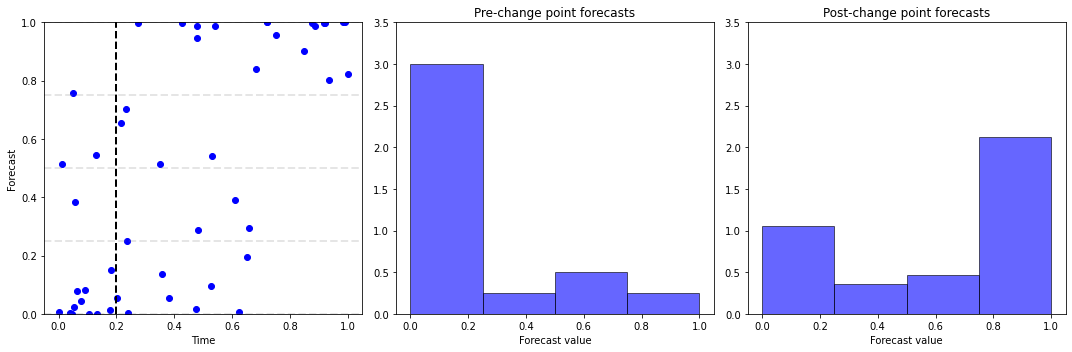

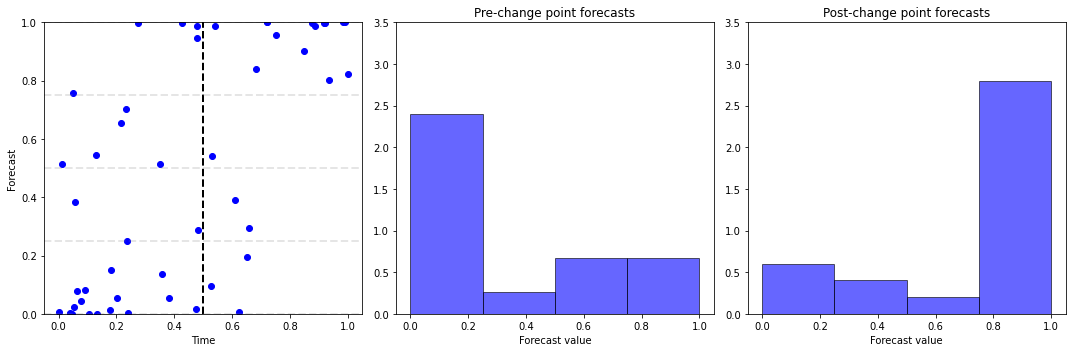

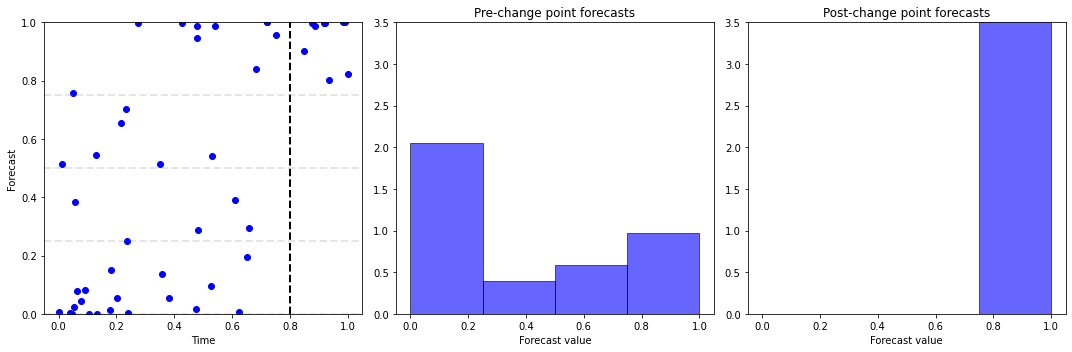

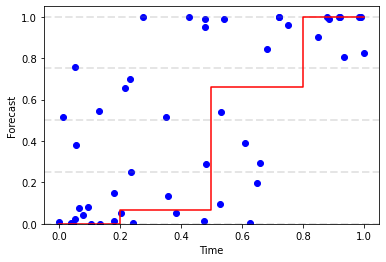

\begin{tabular}{lrrr}
\hline
                                  &   t=0.2 &   t=0.5 &   t=0.8 \\
\hline
 Log-prior                        &  -4.902 &  -3.999 &  -3.289 \\
 Loglike. for earlier forecasts   & -18.317 & -37.015 & -52.957 \\
 Loglike. for later forecasts     & -43.362 & -23.354 &  -8.690 \\
 Unnormalized log-posterior       & -66.581 & -64.368 & -64.936 \\
 Posterior mass funct.            &   0.065 &   0.597 &   0.338 \\
 Posterior cumulative mass funct. &   0.065 &   0.662 &   1.000 \\
\hline
\end{tabular}


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta, geom
from scipy.special import loggamma

np.random.seed(1)

# Specify number of forecasts and simulate their forecast times
n_total = 50
t_vect = np.cumsum(np.concatenate(([0], np.random.exponential(size=n_total-1))))
t_vect = t_vect / t_vect.max()

# Specify potential times for change points
t_star_vect = [0.2, 0.5, 0.8]

def logistic(x):
    return 1 / (1 + np.exp(-x))

# p_vect is a gradually increasing series of 'true' probabilities
# f_vect is a noisy version of p_vect. These are the values of the forecasters' forecasts.
eps = 0.2
p_vect = logistic((t_vect - 0.5) / 0.1) * (1 - 2 * eps) + eps
s = 1
f_vect = beta.rvs(p_vect * s, (1 - p_vect) * s)

# This function computes the log-prob mass for the Dirichlet-categorical distribution
def log_dirichlet(f, bin_breaks, alpha=4):
    counts, _ = np.histogram(f, bins=bin_breaks)
    n_bin = len(counts)
    n_counts = counts
    return (loggamma(alpha * n_bin) - loggamma(sum(n_counts + alpha))
            + sum(loggamma(n_counts + alpha)) - n_bin * loggamma(alpha))

# Prepare table for results
calc_table = np.zeros((6, 3))

bin_breaks = np.linspace(0, 1, 5)
hist_breaks = np.linspace(0, 1, 16)

# The following for-loop computes the 
for i, t_star in enumerate(t_star_vect):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].plot(t_vect, f_vect, 'o', label="Forecast", color='blue', linestyle='None')
    axes[0].axvline(x=t_star, linestyle='--', linewidth=2, color='black')
    for b in bin_breaks:
        axes[0].axhline(y=b, linestyle='--', linewidth=2, color='gray', alpha=0.2)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Forecast')
    axes[0].set_ylim(0, 1)

    # Compute change point likelihoods from forecast counts
    f1 = f_vect[t_vect < t_star]
    loglik1 = log_dirichlet(f1, bin_breaks)
    calc_table[1, i] = loglik1

    f2 = f_vect[t_vect >= t_star]
    loglik2 = log_dirichlet(f2, bin_breaks)
    calc_table[2, i] = loglik2

    # Compute prior for change point
    calc_table[0, i] = geom.logpmf(len(f2), 1 / 16)
    calc_table[3, i] = np.sum(calc_table[0:3, i])

    logpost = calc_table[3, :3] - np.max(calc_table[3, :3])
    post = np.exp(logpost)
    post /= np.sum(post)
    calc_table[4, :3] = post
    calc_table[5, :3] = np.cumsum(post)

    axes[1].hist(f1, bins=bin_breaks, density=True, color='blue', alpha=0.6, edgecolor="black")
    axes[1].set_xlabel("Forecast value")
    axes[1].set_ylim(0, 3.5)
    axes[1].set_title("Pre-change point forecasts")

    axes[2].hist(f2, bins=bin_breaks, density=True, color='blue', alpha=0.6, edgecolor="black")
    axes[2].set_xlabel("Forecast value")
    axes[2].set_ylim(0, 3.5)
    axes[2].set_title("Post-change point forecasts")

    plt.tight_layout()
    plt.show()

xplot = [0] + t_star_vect + [1]
yplot = [0] + calc_table[5, :].tolist() + [1]

plt.figure(figsize=(6, 4))
plt.plot(t_vect, f_vect, 'o', label="Forecast", color='blue', linestyle='None')
for b in bin_breaks:
    plt.axhline(y=b, linestyle='--', linewidth=2, color='gray', alpha=0.2)
plt.step(xplot, yplot, where='post', color='red')
plt.xlabel('Time')
plt.ylabel('Forecast')
plt.ylim(0, 1.05)
plt.show()
plt.close()

import pandas as pd
from tabulate import tabulate
df = pd.DataFrame(calc_table, index=["Log-prior", "Loglike. for earlier forecasts", 
                                     "Loglike. for later forecasts", "Unnormalized log-posterior", 
                                     "Posterior mass funct.", "Posterior cumulative mass funct."], 
                  columns=[f"t={t_star}" for t_star in t_star_vect])

print(tabulate(df, headers="keys", tablefmt="latex", floatfmt=".3f"))


## Appendix B: Non-Probabilistic Questions

In [9]:
#load the forecasts
paths = ['intermediary/appendix_b/forecasts/' + i for i in os.listdir('intermediary/appendix_b/forecasts')]
skills = []
for num, path in enumerate(paths):  
            df = pd.read_pickle(path)
            df['IJF'] = [0.5,0.5,0.5]
            forecast_columns = ['median', 'mean', 'kairosis_median', 'kairosis_mean', 'twenty_median', 'twenty_mean', 'geom_median', 'geom_mean', 'IJF']
            scoredf = df.copy()
            # Apply Brier score to each forecast in each row, using 'resolution' as the outcome
            for col in forecast_columns:
                scoredf[f'brier_{col}'] = scoredf.apply(lambda row: brier_score(row[col], row['resolution']), axis=1)
            scoredf = scoredf.drop(columns = forecast_columns)
            unweighted = pd.DataFrame([scoredf.iloc[:, 2:].mean()])
            weighted = pd.DataFrame([(scoredf.iloc[:, 2:]).mul((scoredf['weight']/scoredf['weight'].sum()), axis = 0).sum()])
            res = pd.concat([unweighted, weighted])
            res.index =  ['unweighted', 'weighted']
            brier_columns = [f'brier_{col}' for col in forecast_columns]
            log_columns = []
            res = res[brier_columns + log_columns]
            brier = res[brier_columns].T
            brieruw = pd.DataFrame(brier.unweighted)
            brierw = pd.DataFrame(brier.weighted)
            brier_uw_skills = []
            brier_w_skills = []

            for i in (brieruw.index[1:]):
                brier_uw_skills.append(skillscorebrier(brieruw.loc['brier_median'].values[0], brieruw.loc[i].values[0]))
                brier_w_skills.append(skillscorebrier(brierw.loc['brier_median'].values[0], brierw.loc[i].values[0]))
            skillscores = pd.DataFrame([brier_uw_skills, brier_w_skills]).T
            skillscores.index =['mean', 'kairosis_median', 'kairosis_mean',
                'twenty_median', 'twenty_mean', 'geom_median',
                'geom_mean', 'IJF']
            skillscores.columns = ['Unweighted Brier Score', 'Weighted Brier Score']
            skills.append(skillscores)
totalskill_check = pd.concat(skills)
totalskill = totalskill_check
cols = []
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Unweighted Brier Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Unweighted Brier Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Unweighted Brier Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Unweighted Brier Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Unweighted Brier Score'].values
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Unweighted Brier Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Unweighted Brier Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Unweighted Brier Score'].values
uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T
uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = normalize_inputs(uwbs)
values = np.sqrt(testdta.var()/testdta.shape[0])
cols.append(testdta.mean())
kariosis_uwb= totalskill[totalskill.index == 'kairosis_median']['Weighted Brier Score'].values
twenty_uwb= totalskill[totalskill.index == 'twenty_median']['Weighted Brier Score'].values
geom_uwb= totalskill[totalskill.index == 'geom_median']['Weighted Brier Score'].values
mean_uwb= totalskill[totalskill.index == 'mean']['Weighted Brier Score'].values
median_uwb= totalskill[totalskill.index == 'IJF']['Weighted Brier Score'].values
kariosis_uwb_mean= totalskill[totalskill.index == 'kairosis_mean']['Weighted Brier Score'].values
twenty_uwb_mean= totalskill[totalskill.index == 'twenty_mean']['Weighted Brier Score'].values
geom_uwb_mean= totalskill[totalskill.index == 'geom_mean']['Weighted Brier Score'].values
uwbs = pd.DataFrame([kariosis_uwb,kariosis_uwb_mean, twenty_uwb,twenty_uwb_mean, geom_uwb,geom_uwb_mean, mean_uwb, median_uwb]).T
uwbs.columns = ['kairosis_median', 'kairosis_mean','twenty_median',  'twenty_mean','geom_median', 'geom_mean', 'mean', 'IJF']
testdta = normalize_inputs(uwbs)
cols.append(testdta.mean())
weighted_values = np.sqrt(testdta.var()/testdta.shape[0])
table1 = pd.DataFrame(cols)
table1['median'] = [0,0]
table1 = (table1.T).round(3)
# Define the desired row order
desired_row_order = [
    'median', 'mean',
    'kairosis_median', 'kairosis_mean', 
    'twenty_median', 'twenty_mean', 
    'geom_median', 'geom_mean', 
    'IJF'
]
df_reordered = table1.loc[desired_row_order]
df_reordered.columns = ['Brier UW','Brier W']
SDs = pd.DataFrame({
    'Brier UW': values,
    'Brier W': weighted_values
})
SDs.loc['median'] = [0,0]
SDs_reordered = SDs.loc[desired_row_order]
t1 = pd.concat([pd.DataFrame(df_reordered.round(3).astype(str) + ' (' + SDs_reordered.round(3).astype(str) + ')')], axis = 1)
print(t1.iloc[:-1])
# Display the DataFrame


                       Brier UW         Brier W
median                0.0 (0.0)       0.0 (0.0)
mean             -1.459 (0.481)  -1.363 (0.458)
kairosis_median   0.042 (0.027)   0.047 (0.026)
kairosis_mean    -2.645 (0.926)  -2.469 (0.884)
twenty_median    -0.709 (0.378)  -0.728 (0.387)
twenty_mean      -3.848 (1.329)   -3.366 (1.08)
geom_median       -0.098 (0.13)  -0.068 (0.091)
geom_mean        -2.695 (0.934)  -2.366 (0.849)


## Appendix C: Sensitivity Analysis

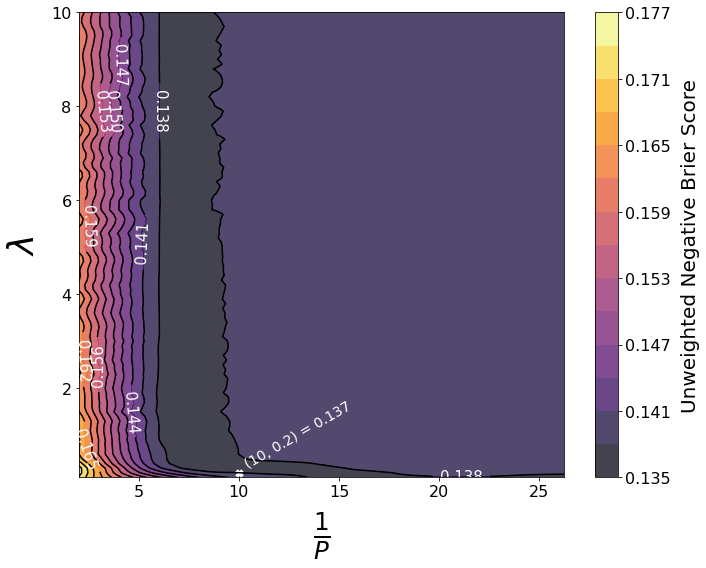

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

data = pd.read_csv('intermediary/appendix_c/grid_search_results.csv')
data = data.iloc[:, 1:]
# Melt the DataFrame
melted_df = data.reset_index().melt(id_vars='index', var_name='old_column', value_name='score')
melted_df
# Rename columns for clarity
melted_df = melted_df.rename(columns={'index': 'alpha',
                                    'old_column' : 'p'})
alphas = np.linspace(.1,10,50)
alphadict = {}
for i,j in zip(np.arange(0,50,1),alphas):
    alphadict[i] = j
melted_df['alpha'] = [alphadict[i] for i in melted_df.alpha.copy()]

ps = np.linspace(2,200,50)
pdict = {}
for i,j in zip(np.arange(0,50,1),ps):
    pdict[i] = j
melted_df['p'] = [pdict[int(i)] for i in melted_df.p.copy()]
melted_df
df = melted_df[melted_df.p < 30]
grid_x, grid_y = np.mgrid[df['p'].min():df['p'].max():100j, df['alpha'].min():df['alpha'].max():100j]
grid_z = griddata((df['p'], df['alpha']), df['score'], (grid_x, grid_y), method='cubic')
# Create a 2D contour plot
plt.figure(figsize=(10, 8), facecolor=(1,1,1))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=15, cmap='inferno', alpha=0.75)
cbar = plt.colorbar(contour)
plt.xlabel(r'$\frac{1}{P}$', fontsize=35, labelpad=10)
plt.ylabel(r'$\lambda$', fontsize=35, labelpad=10)
cbar.set_label('Unweighted Negative Brier Score', fontsize=20, labelpad=10)

contour_lines = plt.contour(grid_x, grid_y, grid_z, levels=15, colors='k', linewidths=1.5)
clabels = plt.clabel(contour_lines, inline=True, fontsize=15, fmt='%1.3f')
for txt in clabels:
    txt.set_color('white')

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16)  
min_idx = np.argmin(df['score'])
min_x, min_y = df['p'].iloc[min_idx], df['alpha'].iloc[min_idx]
plt.text(10, 0.2, r' ' + f'({10:.0f}, {0.2:.1f}) = {0.137}', color='white', fontsize=14, ha='left', va='bottom', rotation = 30)
plt.scatter(10, 0.2, color='white', marker='X', s=50)
cbar.ax.tick_params(labelsize=16)
plt.tight_layout()
plt.show()